In [1]:
# Import libs.
from keras.datasets import imdb
import pandas as pd
import numpy as np
from keras.layers import LSTM, Activation, Dropout, Dense, Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.models import Model
import string
import re
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.sequence import pad_sequences
import keras
from sklearn.model_selection import train_test_split

In [2]:
#Loading the dataset
data = pd.read_csv('Pre_Processed_Dataset.csv')

In [3]:
data.columns

Index(['Review', 'Length', 'Rating', 'Polarity'], dtype='object')

In [4]:
Data_Size = 82000
Data_Segment_1 = data[data['Polarity'] == 0].iloc[:Data_Size,:]
Data_Segment_2 = data[data['Polarity'] == 1].iloc[:Data_Size,:]

# makign new dataframe
New_Instance_dataframe = frames = pd.concat([Data_Segment_1, Data_Segment_2])
New_Instance_dataframe.reset_index(inplace = True, drop = True)

# setting features 
Features_Collection = New_Instance_dataframe['Review']

# setting labels 
Label_Collection = New_Instance_dataframe['Polarity']

In [5]:
reviews = Features_Collection.values
labels = Label_Collection.values

In [6]:
#train test split
X_train, X_test,Y_train, Y_test = train_test_split(reviews, labels, test_size=0.2, random_state = 45)

In [7]:
#tokenisation
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

words_to_index = tokenizer.word_index

In [8]:
maxLen = 150

In [9]:
def read_glove_vector(glove_vec):
  with open(glove_vec, 'r', encoding='UTF-8') as f:
    words = set()
    word_to_vec_map = {}
    for line in f:
      w_line = line.split()
      curr_word = w_line[0]
      word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)



  return word_to_vec_map

In [10]:
word_to_vec_map = read_glove_vector('glove.6B.50d.txt')

In [11]:
vocab_len = len(words_to_index)
embed_vector_len = word_to_vec_map['moon'].shape[0]

emb_matrix = np.zeros((vocab_len, embed_vector_len))

for word, index in words_to_index.items():
  embedding_vector = word_to_vec_map.get(word)
  if embedding_vector is not None:
    emb_matrix[index, :] = embedding_vector

embedding_layer = Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=maxLen, weights = [emb_matrix], trainable=False)

In [12]:
print("vocab length : ",vocab_len)
print("Embedding vector length : ",embed_vector_len)

vocab length :  41455
Embedding vector length :  50


In [13]:
def LSTM_model(input_shape):

  X_indices = Input(input_shape)
  embeddings = embedding_layer(X_indices)
  X = LSTM(128, return_sequences=True)(embeddings)
  X = Dropout(0.6)(X)
  X = LSTM(128, return_sequences=True)(X)
  X = Dropout(0.6)(X)
  X = LSTM(128)(X)
  X = Dense(1, activation='softmax')(X)
  model = Model(inputs=X_indices, outputs=X)
  return model

In [28]:
def conv1d_nn(input_shape):
  X_indices = Input(input_shape)
  embeddings = embedding_layer(X_indices)
  X = LSTM(128, return_sequences=True)(embeddings)
  X = Dropout(0.6)(X)
  X = LSTM(128, return_sequences=True)(X)
  X = Dropout(0.6)(X)
  X = LSTM(128)(X)
  X = Dense(1, activation='sigmoid')(X)
  model = Model(inputs=X_indices, outputs=X)
  return model

In [20]:
model = LSTM_model((maxLen,))
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        multiple                  2072750   
_________________________________________________________________
lstm_3 (LSTM)                (None, 150, 128)          91648     
_________________________________________________________________
dropout_2 (Dropout)          (None, 150, 128)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 150, 128)          131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 150, 128)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               1315

In [16]:
X_train_indices = tokenizer.texts_to_sequences(X_train)

In [29]:
model_1d = conv1d_nn((maxLen,))
model_1d.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        multiple                  2072750   
_________________________________________________________________
lstm_6 (LSTM)                (None, 150, 128)          91648     
_________________________________________________________________
dropout_4 (Dropout)          (None, 150, 128)          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 150, 128)          131584    
_________________________________________________________________
dropout_5 (Dropout)          (None, 150, 128)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 128)               1315

In [17]:
X_train_indices = pad_sequences(X_train_indices, maxlen=maxLen, padding='post')
X_train_indices.shape

(131200, 150)

In [31]:
from tensorflow import keras
adam = keras.optimizers.Adam(learning_rate = 0.0001)
model_1d.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [32]:
X_test.shape

(32800,)

In [34]:
history2 = model_1d.fit(X_train_indices, Y_train, batch_size=64, epochs=25,validation_split=0.1)

Epoch 1/25
1845/1845 [==============================] - 38s 20ms/step - loss: 0.5757 - accuracy: 0.6899 - val_loss: 0.4970 - val_accuracy: 0.7601
Epoch 2/25
1845/1845 [==============================] - 39s 21ms/step - loss: 0.4830 - accuracy: 0.7699 - val_loss: 0.4873 - val_accuracy: 0.7697
Epoch 3/25
1845/1845 [==============================] - 39s 21ms/step - loss: 0.4576 - accuracy: 0.7859 - val_loss: 0.4559 - val_accuracy: 0.7930
Epoch 4/25
1845/1845 [==============================] - 39s 21ms/step - loss: 0.4406 - accuracy: 0.7971 - val_loss: 0.4390 - val_accuracy: 0.8030
Epoch 5/25
1845/1845 [==============================] - 38s 21ms/step - loss: 0.4304 - accuracy: 0.8027 - val_loss: 0.4604 - val_accuracy: 0.7835
Epoch 6/25
1845/1845 [==============================] - 39s 21ms/step - loss: 0.4225 - accuracy: 0.8080 - val_loss: 0.4361 - val_accuracy: 0.7941
Epoch 7/25
1845/1845 [==============================] - 38s 21ms/step - loss: 0.4163 - accuracy: 0.8099 - val_loss: 0.4220 -

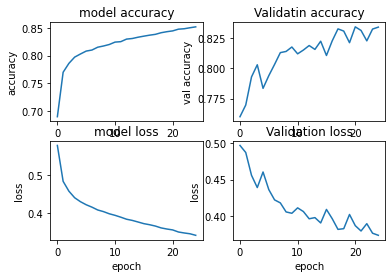

In [37]:
import matplotlib.pyplot as plot
fig = plt.figure()

plt.subplot(2, 2, 1)
plot.plot(history2.history['accuracy'])
plot.title('model accuracy')
plot.ylabel('accuracy')
plot.xlabel('epoch')

plt.subplot(2, 2, 2)
plot.plot(history2.history['val_accuracy'])
plot.title('Validatin accuracy')
plot.ylabel('val accuracy')
plot.xlabel('epoch')

plt.subplot(2, 2, 3)
plot.plot(history2.history['loss'])
plot.title('model loss')
plot.ylabel('loss')
plot.xlabel('epoch')

plt.subplot(2, 2, 4)
plot.plot(history2.history['val_loss'])
plot.title('Validation loss')
plot.ylabel('loss')
plot.xlabel('epoch')
plot.show()

plt.show()

In [18]:
X_test_indices = tokenizer.texts_to_sequences(X_test)

X_test_indices = pad_sequences(X_test_indices, maxlen=maxLen, padding='post')

In [21]:
from tensorflow import keras
adam = keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_indices, Y_train, batch_size=64, epochs=5,validation_split=0.1)

Epoch 1/5
1845/1845 [==============================] - 43s 21ms/step - loss: 0.6258 - accuracy: 0.5000 - val_loss: 0.5329 - val_accuracy: 0.5040
Epoch 2/5
1845/1845 [==============================] - 38s 21ms/step - loss: 0.5014 - accuracy: 0.5000 - val_loss: 0.4774 - val_accuracy: 0.5040
Epoch 3/5
1845/1845 [==============================] - 38s 21ms/step - loss: 0.4648 - accuracy: 0.5000 - val_loss: 0.4461 - val_accuracy: 0.5040
Epoch 4/5
1845/1845 [==============================] - 35s 19ms/step - loss: 0.4480 - accuracy: 0.5000 - val_loss: 0.4382 - val_accuracy: 0.5040
Epoch 5/5
1845/1845 [==============================] - 38s 21ms/step - loss: 0.4361 - accuracy: 0.5000 - val_loss: 0.4355 - val_accuracy: 0.5040


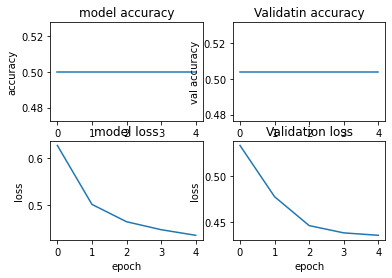

In [36]:
import matplotlib.pyplot as plot
fig = plt.figure()

plt.subplot(2, 2, 1)
plot.plot(history.history['accuracy'])
plot.title('model accuracy')
plot.ylabel('accuracy')
plot.xlabel('epoch')

plt.subplot(2, 2, 2)
plot.plot(history.history['val_accuracy'])
plot.title('Validatin accuracy')
plot.ylabel('val accuracy')
plot.xlabel('epoch')

plt.subplot(2, 2, 3)
plot.plot(history.history['loss'])
plot.title('model loss')
plot.ylabel('loss')
plot.xlabel('epoch')

plt.subplot(2, 2, 4)
plot.plot(history.history['val_loss'])
plot.title('Validation loss')
plot.ylabel('loss')
plot.xlabel('epoch')
plot.show()

plt.show()

In [24]:
print("Conclusion : Conv1d neural newtork perform better than LSTM model, with conv1d neural network we have achived")
print("Training Accuracy : 88.78%")
print("Validation Accuracy : 84.54%")

Conclusion : Conv1d neural newtork perform better than LSTM model, with conv1d neural network we have achived
Training Accuracy : 88.78%
Validation Accuracy : 84.54%


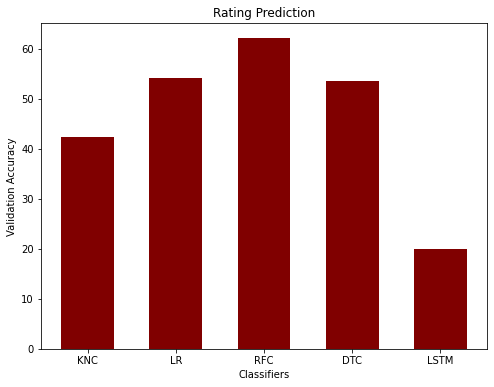

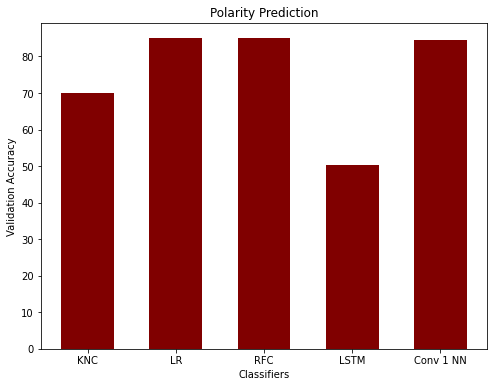

In [23]:
#Analysis
import matplotlib.pyplot as plt
# plotting main graph
Data_Acc = [0.42424, 0.54152, 0.62088, 0.536, 0.1999] 
Data_Acc = [ x*100 for x in Data_Acc]
Names = ['KNC',	'LR', 'RFC', 'DTC', 'LSTM']
plt.figure(figsize=(8, 6))
plt.bar(Names, Data_Acc, color ='maroon', width = 0.6)
plt.title("Rating Prediction")
plt.xlabel("Classifiers")
plt.ylabel("Validation Accuracy")
plt.show()

# plotting main graph
Data_Acc = [70.0, 85.0, 85.0, 50.40, 84.54] 
Names = ['KNC',	'LR', 'RFC', 'LSTM', 'Conv 1 NN']
plt.figure(figsize=(8, 6))
plt.bar(Names, Data_Acc, color ='maroon', width = 0.6)
plt.title("Polarity Prediction")
plt.xlabel("Classifiers")
plt.ylabel("Validation Accuracy")
plt.show()